Предсказание длительности поездки на такси

In [12]:
import os
import shutil

source = "/Users/ildargarifullin/Developer/work python/LinearRegression/kaggle.json"

destination_dir = os.path.expanduser("~/.kaggle")
destination = os.path.join(destination_dir, "kaggle.json")

os.makedirs(destination_dir, exist_ok=True)

shutil.copy(source, destination)

os.chmod(destination, 0o600)

print("✅ kaggle.json успешно установлен!")


✅ kaggle.json успешно установлен!


In [16]:
%pip install kaggle

  Using cached kaggle-1.7.4.5-py3-none-any.whl.metadata (16 kB)
  Using cached bleach-6.2.0-py3-none-any.whl.metadata (30 kB)
  Using cached protobuf-6.32.1-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl.metadata (2.4 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
Using cached kaggle-1.7.4.5-py3-none-any.whl (181 kB)
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
Using cached bleach-6.2.0-py3-none-any.whl (163 kB)
Using cached protobuf-6.32.1-cp39-abi3-macosx_10_9_universal2.whl (426 kB)
Using cached python_slugify-8.0.4-py2.py3-none-any.whl (10 kB)
Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
Using cached webencodings-0.5.1-py2.py3-none-any.whl (11 kB)
   ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/7 [setuptools]  WARNING: Th

In [21]:
!kaggle datasets list | head

ref                                                           title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmadrazakashif/bmw-worldwide-sales-records-20102024          BMW Worldwide Sales Records (2010–2024)                853348  2025-09-20 14:39:45.280000           9449        207  1.0              
jockeroika/life-style-data                                    Life Style Data                                       3995645  2025-10-14 13:50:45.303000           4492        106  0.8235294        
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset  Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000           3308        119  1.0              
jaderz/hospital

In [28]:
!kaggle competitions download -c nyc-taxi-trip-duration

  0%|                                               | 0.00/85.8M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 85.8M/85.8M [00:00<00:00, 1.58GB/s]


Распакую полученные данные

In [29]:
!unzip nyc-taxi-trip-duration.zip

Archive:  nyc-taxi-trip-duration.zip
  inflating: sample_submission.zip   
  inflating: test.zip                
  inflating: train.zip               


Работа только с train частью, тк там есть значения предсказываемой переменной

In [30]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

In [31]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Следует удалить столбец dropoff_datetime тк это время конца поездки, зная его и время начала поездки, можно легко вычилить время поездки

Во время предсказания время окончания поездки (dropoff_datetime) не может быть доступно

In [33]:
df = df.drop('dropoff_datetime', axis=1)

Когда у данных есть дата, появляется временная размерность. Разбиение данных на train и test становится не очевидным. Тк строить модель мы хотим по прошлым данным и работать с ней в будущем. Для train данные берем начиная с какой-то даты до некотрой заранее обусловленной и для test пойдут данные (поездки), которые произошли после этой обусловленной даты

Возможно сортировка данных по определенному столбцу, в нашем случае по дате начала поездки

In [35]:
df = df.sort_values(by='pickup_datetime')

Разбиваю данные на train и test

In [36]:
train_df, test_df = df[:10 ** 6], df[10 ** 6:]

In [37]:
len(test_df), len(train_df)

(458644, 1000000)

Распределение target переменной 

<Axes: >

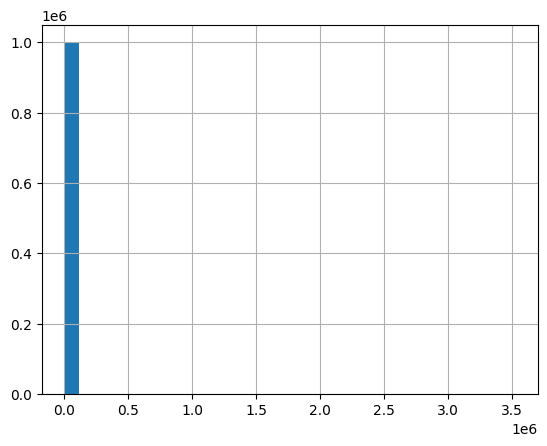

In [39]:
train_df.trip_duration.hist(bins=30)

Если данные сконцентрированы в самом начале (0) и имеют большие выбросы, то полезно посмотреть на логарифм этих данных, который может дать более подробное представление о том, как эти данные устроены

In [40]:
import numpy as np

log1p() - логариф + 1, для того чтобы увидеть данные, которые содержат 0. Например поездка завершилась сразу же (отказ от поездки и прочее). Чтобы не получить log 0 прибавляю единицу

<Axes: >

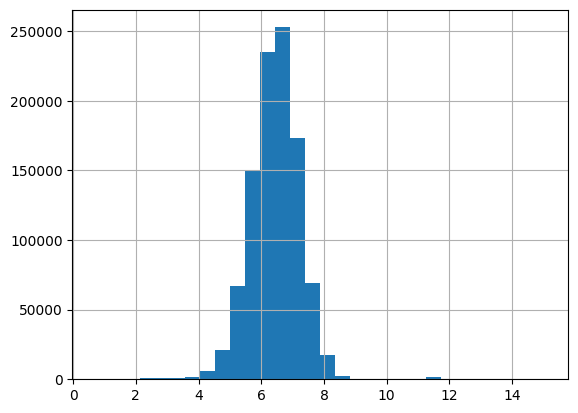

In [43]:
np.log1p(train_df.trip_duration).hist(bins=30)

Следует предсказывать не абсолютный trip_duration, а логарифм trip_duration, иногда это помогает сильно улучшить качество модели, если таргеты распределены нормально

Для этого следует обновить trip_duration, создать новый trip_duration. Обновляю и в test и в train

In [44]:
train_df['log_trip_duration'] = np.log1p(train_df.trip_duration)
test_df['log_trip_duration'] = np.log1p(test_df.trip_duration)

/var/folders/s7/zz5l021j7jq0d45kqm669ntm0000gn/T/ipykernel_1137/389882633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['log_trip_duration'] = np.log1p(train_df.trip_duration)
/var/folders/s7/zz5l021j7jq0d45kqm669ntm0000gn/T/ipykernel_1137/389882633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['log_trip_duration'] = np.log1p(test_df.trip_duration)
